In [123]:
import os
import numpy as np
import keras as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
from keras import metrics
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import pandas as pd

In [68]:
# Model name used to save the weights in h5 format. The name match with the Jupyter notebook

MODEL_NAME = 'model_1'

In [92]:
# DATA PATHS

TRAIN_FOLDER_PATH = '../../data/train/'
VAL_FODLER_PATH = '../../data/validation/'
#TEST_FOLDER_PATH = '../../data/test/'
TEST_FOLDER_PATH = '../../data/test_manual'
PREVIEW_IMAGES_FOLDER = '../../data/preview/'

PREDICTION_FILE_PATH = '../../data/' + MODEL_NAME + '.csv'

In [70]:
# Data augmentation

#datagen = ImageDataGenerator(
#    rotation_range=40,
#    width_shift_range = 0.2,
#    height_shift_range = 0.2,
#    horizontal_flip = True,
#    fill_mode = 'nearest')

#img = load_img(os.path.join(TRAIN_FOLDER_PATH, 'parasitized/cell_1.png'))

#x = img_to_array(img)
#x = x.reshape((1,) + x.shape)

#i = 0
#for batch in datagen.flow(x, batch_size=1, save_to_dir=PREVIEW_IMAGES_FOLDER, save_prefix='cell', save_format='png'):
#    i+=1
#    if i > 5:
#        break

In [71]:
#from IPython.display import Image, display

#for r, d, f in os.walk(PREVIEW_IMAGES_FOLDER):
#    for image in f:
#        display(Image(os.path.join(r, image)))

In [124]:
# MODEL TRAINING CONFIGURATION

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 20
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_FOLDER_PATH,
    target_size = (100,100),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_FODLER_PATH,
    target_size = (100, 100),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    TEST_FOLDER_PATH,
    target_size = (100, 100),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


In [125]:
# Import the architecture/s we want to use and then get the model

#import architecture_2

#arc2 = architecture_2

#model = arc2.get_model()

#model.summary()
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (1,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_51 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_52 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 23, 23, 64)        2112      
__________

In [136]:
def mcc_pred(y_true, y_pred):
    y_pred_pos = K.backend.round(K.backend.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.backend.round(K.backend.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.backend.sum(y_pos * y_pred_pos)
    tn = K.backend.sum(y_neg * y_pred_neg)

    fp = K.backend.sum(y_neg * y_pred_pos)
    fn = K.backend.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.backend.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.backend.epsilon())

In [137]:
#model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
INIT_LR = 1e-2
NUM_EPOCHS = 25

opt = SGD(lr=1e-1, momentum=0.9, decay=1e-1 / NUM_EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy", mcc_pred])

In [138]:
# MODEL TRAINING

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size,
    use_multiprocessing = True
)

model.save_weights(MODEL_NAME + '.h5')

Epoch 1/25
645/645 [==============================] - 60s 93ms/step - loss: 0.6951 - acc: 0.5064 - mcc_pred: 0.0129 - val_loss: 0.6945 - val_acc: 0.5005 - val_mcc_pred: 0.0011
Epoch 2/25
645/645 [==============================] - 60s 93ms/step - loss: 0.6936 - acc: 0.5052 - mcc_pred: 0.0104 - val_loss: 0.6929 - val_acc: 0.5029 - val_mcc_pred: 0.0058
Epoch 3/25
645/645 [==============================] - 60s 93ms/step - loss: 0.6634 - acc: 0.5948 - mcc_pred: 0.1896 - val_loss: 0.5464 - val_acc: 0.8030 - val_mcc_pred: 0.6061
Epoch 4/25
645/645 [==============================] - 59s 92ms/step - loss: 0.3053 - acc: 0.8892 - mcc_pred: 0.7783 - val_loss: 0.2086 - val_acc: 0.9153 - val_mcc_pred: 0.8306
Epoch 5/25
645/645 [==============================] - 59s 92ms/step - loss: 0.2261 - acc: 0.9278 - mcc_pred: 0.8556 - val_loss: 0.2037 - val_acc: 0.9357 - val_mcc_pred: 0.8715
Epoch 6/25
645/645 [==============================] - 59s 92ms/step - loss: 0.2148 - acc: 0.9349 - mcc_pred: 0.8697 - va

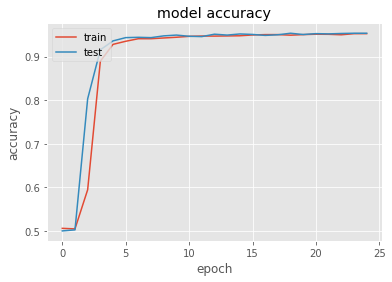

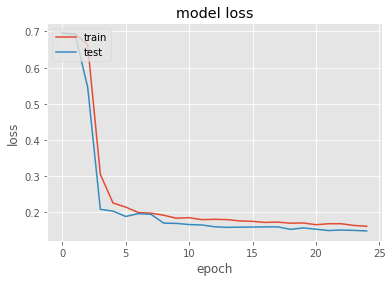

In [139]:
# Plot accuracy and loss values

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
# Evaluate the model

model.evaluate_generator(validation_generator, steps= validation_generator.n // validation_generator.batch_size)


[0.1531784189864993, 0.9529433139534884, 0.9058866279069767]

In [141]:
# Predictions
test_generator.reset()
predIdxs = model.predict_generator(test_generator,steps=(test_generator.n // test_generator.batch_size))

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
 
# show a nicely formatted classification report
print(classification_report(test_generator.classes, predIdxs, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

 parasitized       0.96      0.95      0.96       688
  uninfected       0.96      0.96      0.96       688

    accuracy                           0.96      1376
   macro avg       0.96      0.96      0.96      1376
weighted avg       0.96      0.96      0.96      1376



In [142]:
# METRICS

cm = confusion_matrix(test_generator.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])

print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

acc: 0.9557
sensitivity: 0.9549
specificity: 0.9564


In [143]:
# AUC metrics

X_val_sample, val_labels = next(validation_generator)
val_pred = model.predict_proba(X_val_sample)
val_pred = np.reshape(val_pred, val_labels.shape)
val_score_auc = roc_auc_score(val_labels, val_pred)
print("AUC score: {}".format(val_score_auc))

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

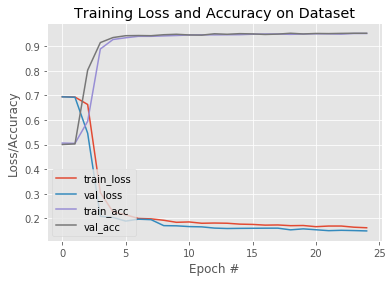

In [144]:
# plot the training loss and accuracy
#N = num_epochs
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")

In [71]:
# Save results into a csv file
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames, "Predictions":predictions})
results.to_csv(PREDICTION_FILE_PATH, index=False)